# Gesture Recognition
To build a model that will be able to predict 5 gestures correctly. 

### <font color='cyan'> Sections in this notebook: </font>
I. Prerequisites
    
    I.1. Importing all the necessary modules
    
II. Custom Generators

    II.1. Abstract base class: Generator
    II.2. Approach 1
    II.3. Approach 2
    II.4. Approach 3

III. Model Deployment
    
    III.1. ModelDeployment Class
    III.2. Let's try various models 
        III.2.1. Inception + RNN
        III.2.2. Custom Conv3d
        III.2.3. Optical flow followed by a custom conv3d network
        III.2.4. Quo Vadis?


    

# <font color='goldenrod'> I. Prerequisites </font>

### <font color='skyblue'>  I.1. Importing all the necessary modules </font> 

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random as rn
import tensorflow as tf
import datetime
import os
from math import ceil

from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

<font color="asparagus"> $\Rightarrow$ Just making sure GPU is getting used</font>

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# <font color='goldenrod'> II. Custom Generators </font>

<font color="asparagus"> $\Rightarrow$ A little heads up about the design used...</font> <br>
- We are going to try different approaches to tackle this problem. 
- All the approaches will require the data to be in a certain way. Therefore, we've opted to create an abstract base class called `Generator`.
- Any generator we write will inherit from this class and they will implement the mandatory virtual functions for them to work.

- As for the working of each method, we have written comments before each method's definition in the abstract class itself. <br> 
- Some generators need additional methods for them to work, in which case, comments will be present before their definition in the children classes. 

### <font color='skyblue'>  II.1. Abstract base class: Generator </font> 

In [3]:
class Generator(keras.utils.Sequence):
    def __init__(self):
        pass

    """ Main logic to get one batch of data is implemented in this method.
     @returns: (batch_data, batch_labels). 
     - The shape of batch_data depends on the type of generator getting used. 
     Regardless, the first dimension will be batch_size
     - batch_labels.shape = (batch_size, numClasses)
    """
    def getBatchData(self, batch, currBatchSize):
        pass

    """ Since all variables are public, this is not really needed. But keeping it anyway.
    # @return: Number of batches to run: depends on total number of videos/batch size 
    """
    def getNumBatches(self):
        pass

    """ 
    - Since we are inheriting from keras.utils.Sequence, we need to implement __getitem__ & __len__.
    - model.fit will call __getitem__ to get one batch of data. 
    - In our implementation, this acts like a wrapper around getBatchData
    """
    def __getitem__(self, batchIdx):
        pass

    """ Returns number of batches """
    def __len__(self):
        pass

### <font color='skyblue'>  II.2. Approach 1 </font> 
<font color="asparagus"> $\Rightarrow$ We use a pretrained CNN model like inception-v3 to extract features & then feed them to RNN to predict the class </font> <br>
<font color="asparagus"> $\Rightarrow$ This is the generator for this purpose: CNNRNNGenerator </font>

In [4]:
class CNNRNNGenerator(Generator):
    """
      Parameters' description:
    - frameIdxList:    Choice left to the user, if user wants to utilize all frames: it'll be list(range(1,30)), since each frame has 30 frames
    - (width, height): Generator resized each frame to (width, height). For inception-v3, the input must of shape (224, 224, 3)
    - source_path:     Path to data(train/val)
    - batch_size:      self-explanatory
    - dataCSV:         <PathToCsv>/<NameOfCSV>.csv
    - numClasses:      For our data, the number of actions = 5: swipe(left to right), swipe(right to left), stop, thumps up, thumps down
    - numFeatures:     Output shape as per feature extractor, in our case, inception-v3, which returns 2048.
    Constructor just caches all the important member variables. Did not want to complicate things with access modifiers, keeping everything public : )
    """
    def __init__(self,
                 frameIdxList,
                 width=224,
                 height=224,
                 source_path=r"D:\DDownloads\UpGrad\NeuralNetwork\CaseStudy\Project_data\train",
                 batch_size=30,
                 dataCSV=r"D:\DDownloads\UpGrad\NeuralNetwork\CaseStudy\Project_data\train.csv",
                 numClasses=5,
                 numFeatures=2048,  # as per inception-v3
                 ):
        super().__init__()
        # Shuffle the data and store in a list
        self.frameIdxList = frameIdxList
        self.numFramesInVideo = len(frameIdxList)
        self.batch_size = batch_size
        self.width = width
        self.height = height
        self.source_path = source_path
        self.dataCSV = dataCSV
        self.numClasses = numClasses
        self.numFeatures = numFeatures

        self.data_doc = np.random.permutation(open(self.dataCSV).readlines())

        # Get vector list
        self.vectorList = np.random.permutation(self.data_doc)
        self.numVideos = len(self.vectorList)
        self.remBatchSize = self.numVideos % self.batch_size
        self.numBatches = ceil(self.numVideos / self.batch_size)
        self.currBatchIdx = 0
        self.numChannels = 3
        self.featureExtractor = None

    """
    Build the feature extractor(inception-v3 in our case) and return it.
    """
    def __build_feature_extractor(self, preTrainedModel="inceptionv3"):
        featureExtractor = None
        if preTrainedModel == "inceptionv3":
            # Disable output layer, so when we do model.predict, it only returns the feature map and the class
            # probabilities. I think imagenet has 1000 classes, we don't need their probabilities.
            featureExtractor = keras.applications.InceptionV3(
                weights="imagenet",
                include_top=False,
                pooling="avg",
                input_shape=(self.width, self.height, self.numChannels))
            # Get preprocess_input from inception_v3 module.
            # This is important because it is responsible for normalizing and converting the image to the format with
            # which inception_v3 was trained on.
            preprocess_input = keras.applications.inception_v3.preprocess_input
            inputs = keras.Input((self.width, self.height, self.numChannels))
            preprocessed = preprocess_input(inputs)
            outputs = featureExtractor(preprocessed)
            return keras.Model(inputs, outputs, name="feature_extractor")
        # Try other feature extractors, if needed
        elif preTrainedModel == "vgg16":
            pass
        else:
            pass
    
    """
    Redundant as numBatches is public, but leaving it as is.
    """
    def getNumBatches(self):
        return self.numBatches

    """ 
    Since we are using inception-v3 to extract features, we'll initialize it with this method
    """
    def initializeFeatureExtractor(self, preTrainedModel="inceptionv3"):
        self.featureExtractor = self.__build_feature_extractor(preTrainedModel)

    """
    As described in Generator class, this returns one batch worth of data which is a tuple of 
    batch_data, whose shape is (batch_size, numFramesInVideo, numFeatures) and
    batch_labels, whose shape is (batch_size, numFramesInVideo, numClasses)
    """
    def getBatchData(self, batch, currBatchSize):
        # The input to RNN will be the output of CNN(inceptionv3)
        # The output of inceptionv3 will be 2048. Since we have 30 frames(numFramesInVideo), batch_data: 30, 2048.
        # Finally, every batch will have this input.
        batch_data = np.zeros((self.batch_size, self.numFramesInVideo, self.numFeatures))
        batch_labels = np.zeros((self.batch_size, self.numFramesInVideo, self.numClasses))
        for batchIdx in range(currBatchSize):
            # Get the vector name (or directory name)
            unprocessedCurrVectorString = self.vectorList[batchIdx + (batch * self.batch_size)].strip()
            vectorName = unprocessedCurrVectorString.split(";")[0]
            # Store vector path
            vectorDir = self.source_path + "\\" + vectorName

            # List all the frames within the directory(vectorName). # Read each image one by one
            allFrames = os.listdir(vectorDir)

            # videoData has all the images imread
            videoData = np.zeros((self.numFramesInVideo, self.width, self.height, self.numChannels))

            # Its corresponding label
            videoLabel = np.zeros((self.numFramesInVideo, self.numClasses))

            # Current video's frames loop
            for frameIdx in self.frameIdxList:
                # Get path of current frame using frameIdx
                currentFrame = vectorDir + "\\" + allFrames[frameIdx]
                # Read image
                frame = cv2.imread(currentFrame).astype(np.float32)
                # Resize the image to what the feature extractor wants
                resizedCurrentFrame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
                # Store frame in videoData tensor.
                videoData[frameIdx,] = resizedCurrentFrame
                # Set the corresponding class' index to 1: One hot encoding
                videoLabel[frameIdx, int(unprocessedCurrVectorString.split(";")[2])] = 1

            batch_data[batchIdx,] = self.featureExtractor.predict(videoData)
            batch_labels[batchIdx,] = videoLabel
        return batch_data, batch_labels

    
    """
    Return number of batches in dataset. Needed as we are inheriting from keras.utils.Sequence
    """
    def __len__(self):
        return self.numBatches
    
    """
    - Needed as we are inheriting from keras.utils.Sequence, model.fit calls __getitem__
    - __getitem__ is a wrapper around getBatchData
    """
    def __getitem__(self, batchIdx):
        # Adjusting batch size as per batchIdx. Remember the last batch may not have enough data to be equal to
        # numVideos/batch_size, it will be equal to numVideos % batch_size.
        currBatchSize = self.batch_size if batchIdx < (self.numVideos // self.batch_size) else self.remBatchSize
        batch_data, batch_labels = self.getBatchData(batchIdx, currBatchSize)
        return batch_data, batch_labels

    """ Keeping this for debugging purposes. Not really needed for the functioning of our code.
        We used it to test generator with next(generator).
    """
    def __next__(self):
        batch_data = None
        batch_labels = None
        # The following logic is to make sure when data is exhausted, the generator starts over from batchIdx = 0
        if self.currBatchIdx < self.__len__():
            batch_data, batch_labels = self.__getitem__(self.currBatchIdx)
            self.currBatchIdx += 1
        else:
            self.currBatchIdx = 0
            batch_data, batch_labels = self.__getitem__(self.currBatchIdx)
        return batch_data, batch_labels

### <font color='skyblue'>  II.3. Approach 2 </font> 
<font color="asparagus"> $\Rightarrow$ This is probably the simplest generator. <br> <font color="asparagus"> $\Rightarrow$ Here we create a custom Conv3D network, therefore the input to this network is the images itself. </font> <br>

In [5]:
class Conv3DGenerator(Generator):
    """
      Parameters' description:
    - frameIdxList:    Choice left to the user, if user wants to utilize all frames: it'll be list(range(1,30)), since each frame has 30 frames
    - (width, height): Generator resized each frame to (width, height). For inception-v3, the input must of shape (224, 224, 3)
    - source_path:     Path to data(train/val)
    - batch_size:      self-explanatory
    - dataCSV:         <PathToCsv>/<NameOfCSV>.csv
    - numClasses:      For our data, the number of actions = 5: swipe(left to right), swipe(right to left), stop, thumps up, thumps down
    Constructor just caches all the important member variables. Did not want to complicate things with access modifiers, keeping everything public : )
    """
    def __init__(self,
                 frameIdxList,
                 width=224,
                 height=224,
                 source_path=r"D:\DDownloads\UpGrad\NeuralNetwork\CaseStudy\Project_data\train",
                 batch_size=30,
                 dataCSV=r"D:\DDownloads\UpGrad\NeuralNetwork\CaseStudy\Project_data\train.csv",
                 numClasses=5):
        super().__init__()
        # Shuffle the data and store in a list
        self.frameIdxList = frameIdxList
        self.numFramesInVideo = len(frameIdxList)
        self.batch_size = batch_size
        self.width = width
        self.height = height

        self.source_path = source_path
        self.dataCSV = dataCSV
        self.numClasses = numClasses
        self.data_doc = np.random.permutation(open(self.dataCSV).readlines())

        # Get vector list
        self.vectorList = np.random.permutation(self.data_doc)
        self.numVideos = len(self.vectorList)
        self.remBatchSize = self.numVideos % self.batch_size
        self.numBatches = ceil(self.numVideos / self.batch_size)
        self.currBatchIdx = 0
        self.numChannels = 3
    
    """
    - Redundant as numBatches is public, but leaving it as is.
    """
    def getNumBatches(self):
        return self.numBatches
    
    """
    - Return number of batches in dataset. Needed as we are inheriting from keras.utils.Sequence
    """
    def __len__(self):
        return self.numBatches
    
    """
    - As described in Generator class, this returns one batch worth of data which is a tuple of 
    batch_data, whose shape is (batch_size, numFramesInVideo, width, height, numChannels) and
    batch_labels, whose shape is (batch_size, numClasses)
    """
    def getBatchData(self, batch, currBatchSize):
        # The input to Conv3d will just be the frames of each video
        batch_data = np.zeros((self.batch_size, self.numFramesInVideo, self.width, self.height, self.numChannels))
        batch_labels = np.zeros((self.batch_size, self.numClasses))
        for batchIdx in range(currBatchSize):
            # Get the vector name (or directory name)
            unprocessedCurrVectorString = self.vectorList[batchIdx + (batch * self.batch_size)].strip()
            vectorName = unprocessedCurrVectorString.split(";")[0]
            # Store vector path
            vectorDir = self.source_path + "\\" + vectorName

            # List all the frames within the directory(vectorName). # Read each image one by one
            allFrames = os.listdir(vectorDir)

            # videoData has all the images imread
            videoData = np.zeros((self.numFramesInVideo, self.width, self.height, self.numChannels))

            # Its corresponding label
            videoLabel = np.zeros((self.numFramesInVideo, self.numClasses))

            # Current video's frames loop
            for frameIdx in self.frameIdxList:
                # Get path of current frame using frameIdx
                currentFrame = vectorDir + "\\" + allFrames[frameIdx]
                # Read image
                frame = cv2.imread(currentFrame).astype(np.float32)

                # Resize the image to (224, 224, 3).
                resizedCurrentFrame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)

                # Normalize
                resizedCurrentFrame = resizedCurrentFrame / 255.0
                # Store frame in videoData tensor.
                videoData[frameIdx,] = resizedCurrentFrame

            batch_data[batchIdx,] = videoData
            # Set the corresponding class' index to 1: One hot encoding
            batch_labels[batchIdx, int(unprocessedCurrVectorString.split(";")[2])] = 1
        return batch_data, batch_labels

    """
    - Needed as we are inheriting from keras.utils.Sequence, model.fit calls __getitem__()
    - __getitem__() is a wrapper around getBatchData
    """
    def __getitem__(self, batchIdx):
        # Adjusting batch size as per batchIdx. Remember the last batch may not have enough data to be equal to
        # numVideos/batch_size, it will be equal to numVideos % batch_size.
        currBatchSize = self.batch_size if batchIdx < (self.numVideos // self.batch_size) else self.remBatchSize
        batch_data, batch_labels = self.getBatchData(batchIdx, currBatchSize)
        return batch_data, batch_labels

    """ 
    - Keeping this for debugging purposes. Not really needed for the functioning of our code.
    - We used it to test generator with next(generator).
    """
    def __next__(self):
        batch_data = None
        batch_labels = None
        # The following logic is to make sure when data is exhausted, the generator starts over from batchIdx = 0
        if self.currBatchIdx < self.__len__():
            batch_data, batch_labels = self.__getitem__(self.currBatchIdx)
            self.currBatchIdx += 1
        else:
            self.currBatchIdx = 0
            batch_data, batch_labels = self.__getitem__(self.currBatchIdx)
        return batch_data, batch_labels

### <font color='skyblue'>  II.4. Approach 3 </font> 
<font color="asparagus"> $\Rightarrow$ Even in this approach, we create a custom Conv3D network like the Conv3DGenerator, but the only difference being the input is not the images. <br> </font>
<font color="asparagus"> $\Rightarrow$ Rather, we obtain a dense optical flow output between consecutive frames and feed that to a Conv3D network to predict the classes. <br>

<font color="asparagus"> $\Rightarrow$ `A bit about Optical Flow` <br>
- Optical flow is known as the pattern of apparent motion of objects, i.e, it is the motion of objects between every two consecutive frames of the sequence, which is caused by the movement of the object being captured or the camera capturing it. Consider an object with intensity I (x, y, t), after time dt, it moves to by dx and dy, now, the new intensity would be, I (x+dx, y+dy, t+dt).
- We, assume that the pixel intensities are constant between the two frames, i.e., 
I (x, y, t) = I (x+dx, y+dy, t+dt) 
Taylor approximation is done on the RHS side, resulting in: 
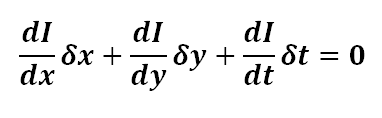
- On dividing by δt, we obtain the Optical Flow Equation, i.e., 
    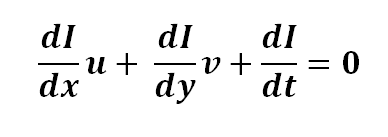
where, u = dx/dt and v = dy/dt. 
- Also, dI/dx is the image gradient along the horizontal axis, dI/dy is the image gradient along the vertical axis and dI/dt is along the time. 
Since, we have just one equation to find two unknowns, we use different approaches to solve this:
- openCV has Lucas-Kanade, which first obtains features like corners using Corner detectors like Shi-Tomasi or Harris Corner detection and obtains the flow vectors for those points only. Therefore, this is termed as sparse optical flow. 
- We wanted the input shape to be fixed and not variable. Therefore, we went with dense optical flow. 
- In dense optical flow, the flow vectors are obtained for each pixel in the frame. So in our case where the image is (224, 224), the output of dense optical flow will be (224,224,2). The '2' captures change in x and y: (dx/dt, dy/dt)
- OpenCV has Gunnar-Farnebäck implemented, which is what we will use.
- FYI, there is a better approach to get dense OF which utilizes SGM(semi global-matching), I leave it up to you read [this paper](https://core.ac.uk/download/pdf/11134866.pdf) for more information

In [76]:
class OpticalFlowGenerator(Generator):
    """
    - The constructor differs slighly from the generators' constructor: 
    - We can use an existing vector list(which has already been shuffled). In such scenarios, we provide two more arguments: useVectorList(a boolean) and the actual vectorList to be used.
    - This was implemented because we wanted to try an approach suggested by this paper: https://arxiv.org/abs/1705.07750
      Parameters' description:
    - frameIdxList:    Choice left to the user, if user wants to utilize all frames: it'll be list(range(1,30)), since each frame has 30 frames
    - (width, height): Generator resized each frame to (width, height). For inception-v3, the input must of shape (224, 224, 3)
    - source_path:     Path to data(train/val)
    - batch_size:      self-explanatory
    - dataCSV:         <PathToCsv>/<NameOfCSV>.csv
    - numClasses:      For our data, the number of actions = 5: swipe(left to right), swipe(right to left), stop, thumps up, thumps down
    - useVectorList:   A boolean to indicate whether we want to use an existing shuffled vector list
    - vectorList:      The vector list to be used.
    Constructor just caches all the important member variables. Did not want to complicate things with access modifiers, keeping everything public : )
    """
    def __init__(self,
                 frameIdxList,
                 width=224,
                 height=224,
                 source_path=r"D:\DDownloads\UpGrad\NeuralNetwork\CaseStudy\Project_data\train",
                 batch_size=30,
                 dataCSV=r"D:\DDownloads\UpGrad\NeuralNetwork\CaseStudy\Project_data\train.csv",
                 numClasses=5,
                 useVectorList=False,
                 vectorList=None):
        super().__init__()
        # Shuffle the data and store in a list
        self.frameIdxList = frameIdxList
        self.numFramesInVideo = int(len(frameIdxList))
        self.batch_size = int(batch_size)
        self.width = int(width)
        self.height = int(height)

        self.source_path = source_path
        self.dataCSV = dataCSV
        self.numClasses = numClasses
        self.data_doc = np.random.permutation(open(self.dataCSV).readlines())

        # Get vector list
        if useVectorList:
            self.vectorList = vectorList
        else:
            self.vectorList = np.random.permutation(self.data_doc)
        self.numVideos = int(len(self.vectorList))
        self.remBatchSize = int(self.numVideos % self.batch_size)
        self.numBatches = int(ceil(self.numVideos / self.batch_size))
        self.currBatchIdx = 0
        self.numChannels = 3
        
    """
    - Redundant as numBatches is public, but leaving it as is.
    """
    def getNumBatches(self):
        return self.numBatches

    """
    - Return number of batches in dataset. Needed as we are inheriting from keras.utils.Sequence
    """
    def __len__(self):
        return self.numBatches

    """
    An extra method needed for this generator, it does the following:
    - Take current and next frame's absolute paths as input arguments.
    - imread the two frames
    - resize to desired size
    - convert to gray(since OF only needs luma component)
    - Get dense OF output using Gunnar Farneback's method
    - Return OF output
    """
    def getOFOutput(self, currFramePath, nextFramePath):
        # Read images
        currFrame = cv2.imread(currFramePath)
        nextFrame = cv2.imread(nextFramePath)

        # Resize to an agreed upon size(Inception wants 224, 224)
        resizedCurrentFrame = cv2.resize(currFrame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        resizedNextFrame = cv2.resize(nextFrame, (self.width, self.height), interpolation=cv2.INTER_AREA)

        # Get the gray versions
        currFrameGray = cv2.cvtColor(resizedCurrentFrame, cv2.COLOR_BGR2GRAY)
        nextFrameGray = cv2.cvtColor(resizedNextFrame, cv2.COLOR_BGR2GRAY)

        flow = cv2.calcOpticalFlowFarneback(prev=currFrameGray, next=nextFrameGray, flow=None, pyr_scale=0.5,
                                            levels=3, winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
        return flow
    
    """
    - As described in Generator class, this returns one batch worth of data which is a tuple of 
    batch_data, whose shape is (batch_size, numFramesInVideo - 1, width, height, 2) and
    batch_labels, whose shape is (batch_size, numClasses)
    Why (numFramesInVideo - 1)? : Because the last frame does not have a target frame i.e. the next frame, so no flow vector for the last frame.
    and 2 because as we described earlier, flow vector: (dx/dt, dy/dt)
    """
    def getBatchData(self, batch, currBatchSize):
        # The input to Conv3d will be the flow output of each frame
        # The last dim is 2 because flow is a vector of dx/dt, dy/dt
        batch_data = np.zeros((self.batch_size, self.numFramesInVideo - 1, self.width, self.height, 2))
        batch_labels = np.zeros((self.batch_size, self.numClasses))
        for batchIdx in range(currBatchSize):
            # Get the vector name (or directory name)
            unprocessedCurrVectorString = self.vectorList[batchIdx + (batch * self.batch_size)].strip()
            vectorName = unprocessedCurrVectorString.split(";")[0]
            # Store vector path
            vectorDir = self.source_path + "\\" + vectorName

            # List all the frames within the directory(vectorName). # Read each image one by one
            allFrames = os.listdir(vectorDir)

            # videoData has all the images' flow outputs
            videoData = np.zeros((self.numFramesInVideo - 1, self.width, self.height,
                                  2))  # The last dim is 2 because flow is a vector of dx/dt, dy/dt

            # Current video's frames loop
            frameIdx = 0
            while frameIdx < (
                    self.numFramesInVideo - 1):  # Flow will have one less frame since it needs (prev, next) pairs
                # Get path of current frame using frameIdx
                currentFrame = vectorDir + "\\" + allFrames[frameIdx]

                # Get path of next frame using frameIdx
                nextFramePath = vectorDir + "\\" + allFrames[frameIdx + 1]

                flow = self.getOFOutput(currFramePath=currentFrame, nextFramePath=nextFramePath)
                videoData[frameIdx,] = flow
                frameIdx += 1
            batch_data[batchIdx,] = videoData
            # Set the corresponding class' index to 1: One hot encoding
            batch_labels[batchIdx, int(unprocessedCurrVectorString.split(";")[2])] = 1
        return batch_data, batch_labels

    """
    - Needed as we are inheriting from keras.utils.Sequence, model.fit calls __getitem__()
    - __getitem__() is a wrapper around getBatchData
    """
    def __getitem__(self, batchIdx):
        # Adjusting batch size as per batchIdx. Remember the last batch may not have enough data to be equal to
        # numVideos/batch_size, it will be equal to numVideos % batch_size.
        currBatchSize = self.batch_size if batchIdx < (self.numVideos // self.batch_size) else self.remBatchSize
        batch_data, batch_labels = self.getBatchData(batchIdx, currBatchSize)
        return batch_data, batch_labels

    """ 
    - Keeping this for debugging purposes. Not really needed for the functioning of our code.
    - We used it to test generator with next(generator).
    """
    def __next__(self):
        batch_data = None
        batch_labels = None
        # The following logic is to make sure when data is exhausted, the generator starts over from batchIdx = 0
        if self.currBatchIdx < self.__len__():
            batch_data, batch_labels = self.__getitem__(self.currBatchIdx)
            self.currBatchIdx += 1
        else:
            self.currBatchIdx = 0
            batch_data, batch_labels = self.__getitem__(self.currBatchIdx)
        return batch_data, batch_labels

# <font color='goldenrod'> III. Model Deployment </font>

### <font color='skyblue'>  III.1. ModelDeployment Class </font> 

<font color="asparagus"> $\Rightarrow$ One ModelDeployment class which has methods to get the various models we have tried. </font> <br>
<font color="asparagus"> $\Rightarrow$ The model returned depends modelType argument given during instance creation. </font> <br>

In [48]:
class ModelDeployment:
    """
    - modelType:               Supported values: cnn-rnn, conv3d, OF or QuoVadis
    - numFeaturesInFirstLayer: Valid for when model is a custom conv3d network.
    - numFrames:               self explanatory
    - input_shape:             A tuple: (width, height, numChannels or 2)
    """
    def __init__(self, input_shape, modelType="OF", numFeaturesInFirstLayer=16, numNeuronsInDenseLayer=128, numFrames=30):
        self.modelType = modelType
        self.numFeaturesInFirstLayer = numFeaturesInFirstLayer
        self.numNeuronsInDenseLayer = numNeuronsInDenseLayer
        self.numFrames = numFrames
        self.input_shape = input_shape
    
    """
    - We had tried quite a few architectures and this one seems to give better results than the others.
    @Returns conv3d model
    """
    def __get_conv3d_model(self):
         # Model
        model = models.Sequential()
        
        # Convolution layer with `numFeaturesInFirstLayer` features, 3x3 filter and a relu activation with 2x2 pooling
        model.add(layers.Conv3D(self.numFeaturesInFirstLayer, (3, 3, 3), padding='same', activation='relu',
                            input_shape=(self.numFrames, self.input_shape[0], self.input_shape[1], self.input_shape[2])))
        model.add(layers.MaxPooling3D())
        
        # Convolution layer with `numFeaturesInFirstLayer * 2` features, 3x3 filter and relu activation with 2x2 pooling
        model.add(layers.Conv3D((self.numFeaturesInFirstLayer * 2), (3, 3, 3), padding='same', activation='relu'))
        model.add(layers.MaxPooling3D())
        
        # Convolution layer with `numFeaturesInFirstLayer * 4` features, 3x3 filter and relu activation with 2x2 pooling
        model.add(layers.Conv3D((self.numFeaturesInFirstLayer * 4), (3, 3, 3), padding='same', activation='relu'))
        model.add(layers.MaxPooling3D())
        
        # Convolution layer with `numFeaturesInFirstLayer * 8` features, 3x3 filter and relu activation with 2x2 pooling
        model.add(layers.Conv3D((self.numFeaturesInFirstLayer * 8), (3, 3, 3), padding='same', activation='relu'))
        model.add(layers.MaxPooling3D())
        
        # Flatten
        model.add(layers.Flatten())
        
        # Add dense layer
        model.add(layers.Dense(self.numNeuronsInDenseLayer, activation='relu'))
        model.add(Dropout(0.4))
        
        #Output layer
        model.add(layers.Dense(5, activation="softmax"))
        
        # Set optimizer, compile & return model
        optimiser = "adam"
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        #print(model.summary())
        return model
        
    """
    - We tried quite a few architectures and this one seems to give better results than the others.
    @Returns rnn model that takes input from a pretrained cnn model like inception-v3
    """
    def __get_rnn_model(self, numFrames=30, numFeatures=2048):
        frame_features_input = keras.Input(shape=(numFrames, numFeatures))
        x = GRU(16, return_sequences=True)(frame_features_input)
        # x = GRU(8, return_sequences=True)(x)
        x = Dropout(0.3)(x)
        x = Dense(32, activation="relu")(x)  # Adding one dense layer
        dense = Dense(5, activation="softmax")
        outputs = TimeDistributed(dense)(x)
        rnn_model = keras.Model(inputs=frame_features_input, outputs=outputs)
        rnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        return rnn_model
    
    """ 
    - When model is rnn, this method creates a directory to cache the best model and adds ReduceLROnPlateau to the callback list
    @Returns callback list
    """
    def __get_rnn_callback(self):
        curr_dt_time = datetime.datetime.now()
        model_name = r"rcnn\rcnn_init" + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '\\'
        currDir = os.getcwd()
        if not os.path.exists(currDir + "\\" + "rcnn"):
            os.mkdir(currDir + "\\" + "rcnn")

        modelPath = currDir + "\\" + model_name
        if not os.path.exists(modelPath):
            os.mkdir(modelPath)

        filepath = modelPath + 'rcnn-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.h5'
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
                                     save_best_only=True, save_weights_only=False,
                                     mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2,
                               min_lr=1e-4)  # write the REducelronplateau code here
        return [checkpoint, LR]
    
    """ 
    - When model is conv3d or OF, this method creates a directory to cache the best model and adds ReduceLROnPlateau to the callback list
    @Returns callback list
    """    
    def __get_conv3d_callback(self):
        curr_dt_time = datetime.datetime.now()
        model_name = None
        currDir = os.getcwd()
        if self.modelType == "conv3d":
            model_name = r"conv3d\conv3d_init" + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '\\'
            if not os.path.exists(currDir + "\\" + "conv3d"):
                os.mkdir(currDir + "\\" + "conv3d")
        elif self.modelType == "OF":
            model_name = r"conv3d_of\conv3d_init" + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '\\'
            if not os.path.exists(currDir + "\\" + "conv3d_of"):
                os.mkdir(currDir + "\\" + "conv3d_of")
        
        modelPath = currDir + "\\" + model_name       
        if not os.path.exists(modelPath):
            os.mkdir(modelPath)
        filepath = modelPath + 'conv3d-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
                                 save_best_only=True, save_weights_only=False,
                                 mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2,
                           min_lr=1e-4)
        return [checkpoint, LR]
        
    """
    - User gets the corresponding model and callback list based on the type he set during instance creation of this class
    """
    def getModel(self):
        if self.modelType == "cnn-rnn":
            return (self.__get_rnn_model(), self.__get_rnn_callback())
        elif self.modelType == "conv3d" or self.modelType == "OF":
            return (self.__get_conv3d_model(), self.__get_conv3d_callback())
        elif self.modelType == "QuoVadis":
            pass
        else:
            print("ERROR: Should not come here, please set modelType to cnn-rnn, conv3d, OF or QuoVadis")        

<font color="asparagus"> $\Rightarrow$ Initialize Seeds

In [8]:
def initializeSeeds():
    np.random.seed(30)
    rn.seed(30)
    tf.random.set_seed(30)

### <font color='skyblue'>  III.2. Let's try various models </font> 

In [9]:
initializeSeeds()

<font color="asparagus"> $\Rightarrow$ Some constants

In [15]:
frameIdxList = list(range(0, 30))
width = 224
height = 224
numChannels = 3
numClasses = 5
batch_size = 10
num_epochs = 15
val_path = r"D:\DDownloads\UpGrad\NeuralNetwork\CaseStudy\Project_data\val"
val_csv = r"D:\DDownloads\UpGrad\NeuralNetwork\CaseStudy\Project_data\val.csv"
numFeaturesInFirstLayer = 16
numNeuronsInDenseLayer = 128

#### III.2.1 Inception + RNN

In [11]:
modelType = "cnn-rnn"

In [12]:
modelDeployment = ModelDeployment(input_shape=(width, height, numChannels), modelType=modelType)

In [13]:
# Generators
train_gen = CNNRNNGenerator(frameIdxList=frameIdxList, batch_size=batch_size)
train_gen.initializeFeatureExtractor()

val_gen = CNNRNNGenerator(frameIdxList=frameIdxList, source_path=val_path, batch_size=batch_size,
                          dataCSV=val_csv)
val_gen.initializeFeatureExtractor()

In [14]:
model, callbacks_list = modelDeployment.getModel()

In [16]:
# Training model
model.fit(train_gen,
          steps_per_epoch=train_gen.getNumBatches(),
          epochs=num_epochs,
          verbose=1,
          validation_data=val_gen,
          validation_steps=val_gen.getNumBatches(),
          workers=6,
          use_multiprocessing=False,
          initial_epoch=0,
          callbacks=callbacks_list)

1/1 [==============================] - 0s 37ms/step
Epoch 1/15
1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 101ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 38ms/step

Epoch 1: val_loss improved from inf to 1.46675, saving model to D:\DDownloads\AnacondaStuff\rcnn\rcnn_init_2023-01-0419_08_20.427368\rcnn-00001-1.54574-0.27343-1.46675-0.40267.h5
67/67 [==============================] - 132s 2s/step - loss: 1.5457 - accuracy: 0.2734 - val_loss: 1.4667 - val_accuracy: 0.4027 - lr: 0.0010
Epoch 2/15
1/1 [==============================] - 0s 124ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 158ms/step


1/1 [==============================] - 0s 146ms/step


1/1 [==============================] - 0s 42ms/step

Epoch 2: val_loss improved from 1.46675 to 1.23514, saving model to D:\DDownloads\AnacondaStuff\rcnn\rcnn_init_2023-01-0419_08_20.427368\rcnn-00002-1.34116-0.45219-1.23514-0.60467.h5
67/67 [==============================] - 88s 1s/step - loss: 1.3412 - accuracy: 0.4522 - val_loss: 1.2351 - val_accuracy: 0.6047 - lr: 0.0010
Epoch 3/15
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 112ms/step


1/1 [==============================] - 0s 101ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 170ms/step

Epoch 3: val_loss improved from 1.23514 to 1.05844, saving model to D:\DDownloads\AnacondaStuff\rcnn\rcnn_init_2023-01-0419_08_20.427368\rcnn-00003-1.14845-0.55871-1.05844-0.61933.h5
67/67 [==============================] - 90s 1s/step - loss: 1.1484 - accuracy: 0.5587 - val_loss: 1.0584 - val_accuracy: 0.6193 - lr: 0.0010
Epoch 4/15
1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 154ms/step


1/1 [==============================] - 0s 53ms/step

Epoch 4: val_loss improved from 1.05844 to 0.91867, saving model to D:\DDownloads\AnacondaStuff\rcnn\rcnn_init_2023-01-0419_08_20.427368\rcnn-00004-1.00296-0.61318-0.91867-0.64133.h5
67/67 [==============================] - 90s 1s/step - loss: 1.0030 - accuracy: 0.6132 - val_loss: 0.9187 - val_accuracy: 0.6413 - lr: 0.0010
Epoch 5/15
1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 155ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 292ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 38ms/step

Epoch 5: val_loss improved from 0.91867 to 0.83133, saving model to D:\DDownloads\AnacondaStuff\rcnn\rcnn_init_2023-01-0419_08_20.427368\rcnn-00005-0.82848-0.68159-0.83133-0.67433.h5
67/67 [==============================] - 90s 1s/step - loss: 0.8285 - accuracy: 0.6816 - val_loss: 0.8313 - val_accuracy: 0.6743 - lr: 0.0010
Epoch 6/15
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 67ms/step loss: 0.7302 - accuracy: 0.71


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 172ms/step


1/1 [==============================] - 0s 162ms/step


1/1 [==============================] - 0s 44ms/step

Epoch 6: val_loss improved from 0.83133 to 0.79015, saving model to D:\DDownloads\AnacondaStuff\rcnn\rcnn_init_2023-01-0419_08_20.427368\rcnn-00006-0.72298-0.71562-0.79015-0.70400.h5
67/67 [==============================] - 93s 1s/step - loss: 0.7230 - accuracy: 0.7156 - val_loss: 0.7902 - val_accuracy: 0.7040 - lr: 0.0010
Epoch 7/15
1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 105ms/steploss: 0.5864 - accuracy: 0.75


1/1 [==============================] - 0s 137ms/step


1/1 [==============================] - 0s 139ms/step


1/1 [==============================] - 0s 134ms/step


1/1 [==============================] - 0s 39ms/step

Epoch 7: val_loss improved from 0.79015 to 0.68618, saving model to D:\DDownloads\AnacondaStuff\rcnn\rcnn_init_2023-01-0419_08_20.427368\rcnn-00007-0.65400-0.74313-0.68618-0.73433.h5
67/67 [==============================] - 94s 1s/step - loss: 0.6540 - accuracy: 0.7431 - val_loss: 0.6862 - val_accuracy: 0.7343 - lr: 0.0010
Epoch 8/15
1/1 [==============================] - 0s 146ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 117ms/steploss: 0.5756 - accuracy: 0.79


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 162ms/step


1/1 [==============================] - 0s 71ms/step

Epoch 8: val_loss improved from 0.68618 to 0.64325, saving model to D:\DDownloads\AnacondaStuff\rcnn\rcnn_init_2023-01-0419_08_20.427368\rcnn-00008-0.57464-0.77876-0.64325-0.78800.h5
67/67 [==============================] - 95s 1s/step - loss: 0.5746 - accuracy: 0.7788 - val_loss: 0.6432 - val_accuracy: 0.7880 - lr: 0.0010
Epoch 9/15
1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 119ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 105ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 145ms/step

Epoch 9: val_loss improved from 0.64325 to 0.62662, saving model to D:\DDownloads\AnacondaStuff\rcnn\rcnn_init_2023-01-0419_08_20.427368\rcnn-00009-0.51793-0.79647-0.62662-0.78400.h5
67/67 [==============================] - 98s 1s/step - loss: 0.5179 - accuracy: 0.7965 - val_loss: 0.6266 - val_accuracy: 0.7840 - lr: 0.0010
Epoch 10/15
1/1 [==============================] - 0s 62ms/steploss: 0.3794 - accuracy: 0.881


1/1 [==============================] - 0s 131ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 108ms/step


1/1 [==============================] - 0s 40ms/step

Epoch 10: val_loss improved from 0.62662 to 0.59647, saving model to D:\DDownloads\AnacondaStuff\rcnn\rcnn_init_2023-01-0419_08_20.427368\rcnn-00010-0.46071-0.82204-0.59647-0.80600.h5
67/67 [==============================] - 97s 1s/step - loss: 0.4607 - accuracy: 0.8220 - val_loss: 0.5965 - val_accuracy: 0.8060 - lr: 0.0010
Epoch 11/15
1/1 [==============================] - 0s 135ms/step


1/1 [==============================] - 0s 140ms/steploss: 0.4366 - accuracy: 0.84


1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 221ms/step


1/1 [==============================] - 0s 381ms/step


1/1 [==============================] - 0s 168ms/step


1/1 [==============================] - 0s 94ms/step

Epoch 11: val_loss improved from 0.59647 to 0.56150, saving model to D:\DDownloads\AnacondaStuff\rcnn\rcnn_init_2023-01-0419_08_20.427368\rcnn-00011-0.41246-0.83801-0.56150-0.80967.h5
67/67 [==============================] - 100s 1s/step - loss: 0.4125 - accuracy: 0.8380 - val_loss: 0.5615 - val_accuracy: 0.8097 - lr: 0.0010
Epoch 12/15
1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 136ms/step


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 137ms/step


1/1 [==============================] - 0s 116ms/step


1/1 [==============================] - 0s 149ms/step

Epoch 12: val_loss did not improve from 0.56150
67/67 [==============================] - 101s 1s/step - loss: 0.4086 - accuracy: 0.8382 - val_loss: 0.6383 - val_accuracy: 0.7987 - lr: 0.0010
Epoch 13/15
1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 227ms/step


1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 39ms/step

Epoch 13: val_loss did not improve from 0.56150
67/67 [==============================] - 106s 1s/step - loss: 0.3606 - accuracy: 0.8570 - val_loss: 0.6256 - val_accuracy: 0.7810 - lr: 0.0010
Epoch 14/15
1/1 [==============================] - 0s 108ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 81ms/step

Epoch 14: val_loss improved from 0.56150 to 0.53769, saving model to D:\DDownloads\AnacondaStuff\rcnn\rcnn_init_2023-01-0419_08_20.427368\rcnn-00014-0.28827-0.88881-0.53769-0.82867.h5
67/67 [==============================] - 103s 1s/step - loss: 0.2883 - accuracy: 0.8888 - val_loss: 0.5377 - val_accuracy: 0.8287 - lr: 1.0000e-04
Epoch 15/15
1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 107ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 103ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 120ms/step

Epoch 15: val_loss did not improve from 0.53769
67/67 [==============================] - 114s 2s/step - loss: 0.2743 - accuracy: 0.8965 - val_loss: 0.5382 - val_accuracy: 0.8237 - lr: 1.0000e-04


1/1 [==============================] - 0s 39ms/step


<font color="asparagus"> $\Rightarrow$ *Observations and Comments*
- Our best model is obtained on the 14th epoch with a training accuracy of 88.8% and validation accuracy of 82.9%.
- Because of our callbacks list, A new directory within rcnn is created: rcnn_init_2023-01-0419_08_20.427368 which houses all our best models. 
- I see accuracy improving after every epoch up to 11th epoch. The validation loss did not improve for the 12th and the 13th epoch, therefore models at were not saved at these two epochs. 
- But the 14th epoch's model gives the best performance on validation data.

#### III.2.2 Custom Conv3d

In [17]:
convTrainGen = Conv3DGenerator(frameIdxList=frameIdxList, batch_size=batch_size)
convValGen = Conv3DGenerator(frameIdxList=frameIdxList, source_path=val_path, batch_size=batch_size,
                             dataCSV=val_csv)

In [18]:
modelType = "conv3d"

In [23]:
convModelDeployment = ModelDeployment(input_shape=(width, height, numChannels), modelType=modelType)

In [24]:
model, callbacks_list = convModelDeployment.getModel()

In [25]:
history = model.fit(convTrainGen,
                  steps_per_epoch=convTrainGen.getNumBatches(),
                  epochs=num_epochs,
                  verbose=1,
                  validation_data=convValGen,
                  validation_steps=convValGen.getNumBatches(),
                  workers=4,
                  class_weight=None,
                  initial_epoch=0,
                  callbacks=callbacks_list)

Epoch 1/15
67/67 [==============================] - ETA: 0s - loss: 1.5235 - categorical_accuracy: 0.3015
Epoch 1: val_loss improved from inf to 1.15695, saving model to D:\DDownloads\AnacondaStuff\conv3d\conv3d_init_2023-01-0419_38_59.742311\conv3d-00001-1.52348-0.30149-1.15695-0.47000.h5
67/67 [==============================] - 118s 2s/step - loss: 1.5235 - categorical_accuracy: 0.3015 - val_loss: 1.1569 - val_categorical_accuracy: 0.4700 - lr: 0.0010
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 1.1442 - categorical_accuracy: 0.4985
Epoch 2: val_loss improved from 1.15695 to 0.80722, saving model to D:\DDownloads\AnacondaStuff\conv3d\conv3d_init_2023-01-0419_38_59.742311\conv3d-00002-1.14418-0.49851-0.80722-0.70000.h5
67/67 [==============================] - 476s 5s/step - loss: 1.1442 - categorical_accuracy: 0.4985 - val_loss: 0.8072 - val_categorical_accuracy: 0.7000 - lr: 0.0010
Epoch 3/15
67/67 [==============================] - ETA: 0s - loss: 0.7319 - cat

<font color="asparagus"> $\Rightarrow$ *Observations and Comments*
- Our best model is obtained on the 8th epoch with a training accuracy of 93.2% and validation accuracy of 87%.
- After that, the accuracy improves, but we start entering the territory of overfitting. Moreover, the validation loss starts to rise after that

#### III.2.3 Optical flow followed by a custom conv3d network

In [77]:
modelType = "OF"
ofModelDeployment = ModelDeployment(input_shape=(width, height, 2), 
                                    modelType=modelType,
                                    numFrames=int(len(frameIdxList) - 1))

In [78]:
trainOFGen = OpticalFlowGenerator(frameIdxList=frameIdxList, batch_size=batch_size)
valOFGen = OpticalFlowGenerator(frameIdxList=frameIdxList, source_path=val_path, batch_size=batch_size/2,
                                dataCSV=val_csv)

In [79]:
model, callbacks_list = ofModelDeployment.getModel()

In [80]:
history = model.fit(trainOFGen,
                    steps_per_epoch=trainOFGen.getNumBatches(),
                    epochs=num_epochs,
                    verbose=1,
                    validation_data=valOFGen,
                    validation_steps=valOFGen.getNumBatches(),
                    workers=4,
                    class_weight=None,
                    initial_epoch=0,
                    callbacks=callbacks_list)

Epoch 1/15
67/67 [==============================] - ETA: 0s - loss: 1.0579 - categorical_accuracy: 0.5985
Epoch 1: val_loss improved from inf to 0.67216, saving model to D:\DDownloads\AnacondaStuff\conv3d_of\conv3d_init_2023-01-0422_25_15.067404\conv3d-00001-1.05787-0.59851-0.67216-0.79000.h5
67/67 [==============================] - 172s 2s/step - loss: 1.0579 - categorical_accuracy: 0.5985 - val_loss: 0.6722 - val_categorical_accuracy: 0.7900 - lr: 0.0010
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 0.6324 - categorical_accuracy: 0.7746
Epoch 2: val_loss improved from 0.67216 to 0.43016, saving model to D:\DDownloads\AnacondaStuff\conv3d_of\conv3d_init_2023-01-0422_25_15.067404\conv3d-00002-0.63244-0.77463-0.43016-0.85000.h5
67/67 [==============================] - 149s 2s/step - loss: 0.6324 - categorical_accuracy: 0.7746 - val_loss: 0.4302 - val_categorical_accuracy: 0.8500 - lr: 0.0010
Epoch 3/15
67/67 [==============================] - ETA: 0s - loss: 0.5222

<font color="asparagus"> $\Rightarrow$ *Observations and Comments*
- Our best model is obtained on the 11th epoch with a training accuracy of 93% and validation accuracy of 94%.
- This approach outperforms all the experiments we've tried. This is because optical flow is best advisable when you want to get the motion between frames. Motion is what we are using to predict the action being performed. 
- There is also a better approach suggested using SGM, but openCV doesn't really have an OF implementation of it. It has a stereo correspondence implementation. We could potentially write our own SGM based implementation to get OF and see how it affects the performance

#### III.2.4 Quo Vadis?

#### Procedure :
- Load best conv3d model and best of model. 
- Get their generators. 
- Get predictions on validation data.
- Average the prediction probabilities and get prediction with argmax.
- Compare against ground truth

In [81]:
conv3dModel = models.load_model(
            r"D:\DDownloads\AnacondaStuff\conv3d\conv3d_init_2023-01-0419_38_59.742311\conv3d-00008-0.16441-0.93284-0.42738-0.87000.h5")

ofModel = models.load_model(
    r"D:\DDownloads\AnacondaStuff\conv3d_of\conv3d_init_2023-01-0422_25_15.067404\conv3d-00010-0.19103-0.93134-0.27275-0.94000.h5")

In [82]:
 # Get val generator for Conv3d
convValGen = Conv3DGenerator(frameIdxList=frameIdxList, source_path=val_path, batch_size=batch_size,
                             dataCSV=val_csv)
# Get val generator for OF-Conv3d. Use the same data_doc as above
valOFGen = OpticalFlowGenerator(frameIdxList=frameIdxList, source_path=val_path, batch_size=batch_size,
                                dataCSV=val_csv, useVectorList=True, vectorList=convValGen.vectorList)

<font color="asparagus"> $\Rightarrow$ Logic for consolidating the results of the two models

In [83]:
def getQuoVadisAccuracy(convValGen, valOFGen, conv3dModel, ofModel):
    noOfEqual = 0
    totalNoOfIters = (valOFGen.numVideos / valOFGen.batch_size)
    iter = 0
    for ((convBatchData, convBatchLabels), (ofBatchData, ofBatchLabels)) in zip(convValGen, valOFGen):
        # Conv3D model's pred
        conv3dPreds = conv3dModel.predict(convBatchData)

        # OF model's pred
        ofModelPreds = ofModel.predict(ofBatchData)

        # Averaging the two
        final_predProbas = (ofModelPreds + conv3dPreds) / 2

        # Obtaining predictions with argmax
        final_pred = np.argmax(final_predProbas, axis=1)  # Max across each row

        # Obtain acutal label
        actualLabel = np.argmax(convBatchLabels, axis=1)

        # For calculating accuracy:
        noOfEqual += sum([1 for pred, act in zip(final_pred, actualLabel) if pred == act])
        iter += 1
        if iter >= totalNoOfIters: break
    return ((noOfEqual/valOFGen.numVideos) * 100)

In [84]:
consolidatedAccuracy = getQuoVadisAccuracy(convValGen=convValGen, valOFGen=valOFGen, 
                                           conv3dModel=conv3dModel, ofModel=ofModel)

1/1 [==============================] - 0s 65ms/step


<font color="asparagus"> $\Rightarrow$ Observations: <br> </font>
- Welp! 93% validation accuracy.  The Quo Vadis paper suggested that with the added complexity we should get a better result. In our 

In [85]:
consolidatedAccuracy

93.0